In [1]:
# Basic libraries for data handling and visualization
import os
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow and Keras modules for deep learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [2]:
# Set the base dataset directory (adjust path as needed)
BASE_DIR = "../dataset"

# Train and test folders
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")

# Hyperparameters
IMAGE_SIZE = (150, 150)   # Resize all images to 150x150
BATCH_SIZE = 32           # Number of images per training batch
EPOCHS = 10               # Number of times the model sees the full training set


In [3]:
# Data Preprocessing with ImageDataGenerator

# Create an ImageDataGenerator for training and validation (with 20% validation split)
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Binary classification: NORMAL or PNEUMONIA
    subset='training'
)

# Validation data generator
val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# Separate data generator for test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # Important for evaluation
)



Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
# Build the Custom CNN Model

# Define a basic Convolutional Neural Network
model = Sequential([
    # First convolution + pooling
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    # Second convolution + pooling
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Third convolution + pooling
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flatten to 1D vector
    Flatten(),

    # Fully connected layer
    Dense(128, activation='relu'),

    # Dropout to prevent overfitting
    Dropout(0.5),

    # Output layer (sigmoid for binary classification)
    Dense(1, activation='sigmoid')
])

# Compile the model with optimizer, loss function, and metrics
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Show model architecture
model.summary()


f:\Kaggle\pneumonia-xray-classifier\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Train the Model

# Save the best model during training (based on validation accuracy)
checkpoint = ModelCheckpoint("../models/custom_cnn.keras", save_best_only=True)

# Stop early if validation accuracy doesn't improve after 3 epochs
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

# Start training the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop]
)


f:\Kaggle\pneumonia-xray-classifier\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.8133 - loss: 0.4125 - val_accuracy: 0.9425 - val_loss: 0.1617
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 92s 698ms/step - accuracy: 0.9515 - loss: 0.1288 - val_accuracy: 0.9415 - val_loss: 0.1510
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 95s 722ms/step - accuracy: 0.9641 - loss: 0.1009 - val_accuracy: 0.9530 - val_loss: 0.1202
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 92s 701ms/step - accuracy: 0.9661 - loss: 0.0875 - val_accuracy: 0.9607 - val_loss: 0.1126
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 90s 686ms/step - accuracy: 0.9672 - loss: 0.0910 - val_accuracy: 0.9521 - val_loss: 0.1463
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 91s 691ms/step - accuracy: 0.9733 - loss: 0.0705 - val_accuracy: 0.9540 - val_loss: 0.1565
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 91s 697ms/step - accuracy: 0.9748 - loss: 0.0729 - val_accuracy: 0.9655 - val_loss: 0.1050
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 90s 685ms/step - accuracy: 0.9875 - loss: 0.0

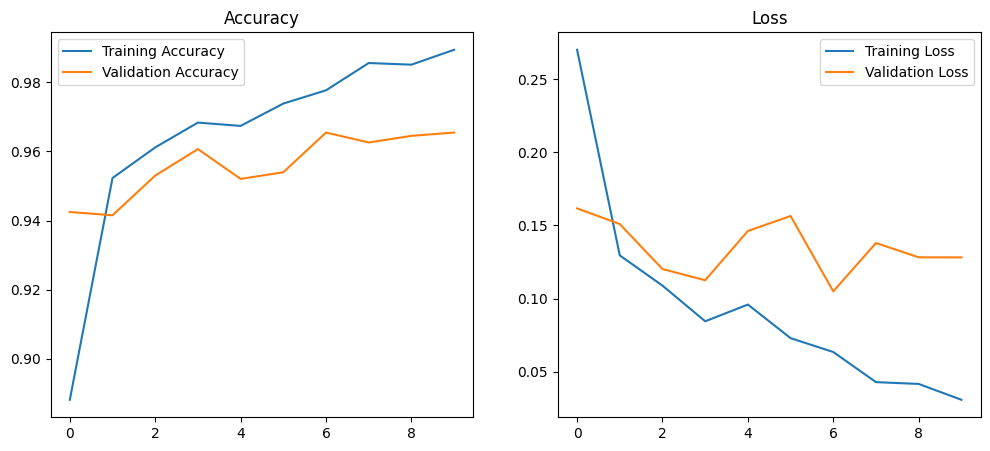

In [6]:
#  Plot Accuracy and Loss

# Function to visualize training and validation accuracy/loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

# Call the function to display plots
plot_training_history(history)


In [7]:
#save the model
model.save("../models/custom_cnn_final.keras")

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 653ms/step
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.97      0.36      0.53       234
   PNEUMONIA       0.72      0.99      0.84       390

    accuracy                           0.76       624
   macro avg       0.84      0.68      0.68       624
weighted avg       0.81      0.76      0.72       624



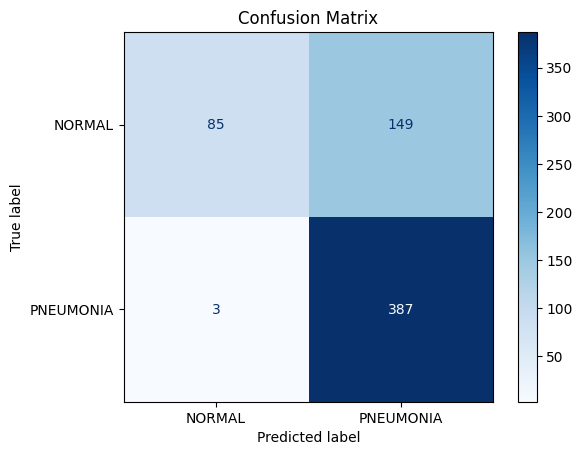

In [ ]:
# Test and Evaluate the Model

# Getting:
    # Precision / Recall / F1-score, for both NORMAL and PNEUMONIA classes
    # Confusion matrix

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict on the test set
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# True labels
y_true = test_generator.classes

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NORMAL", "PNEUMONIA"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


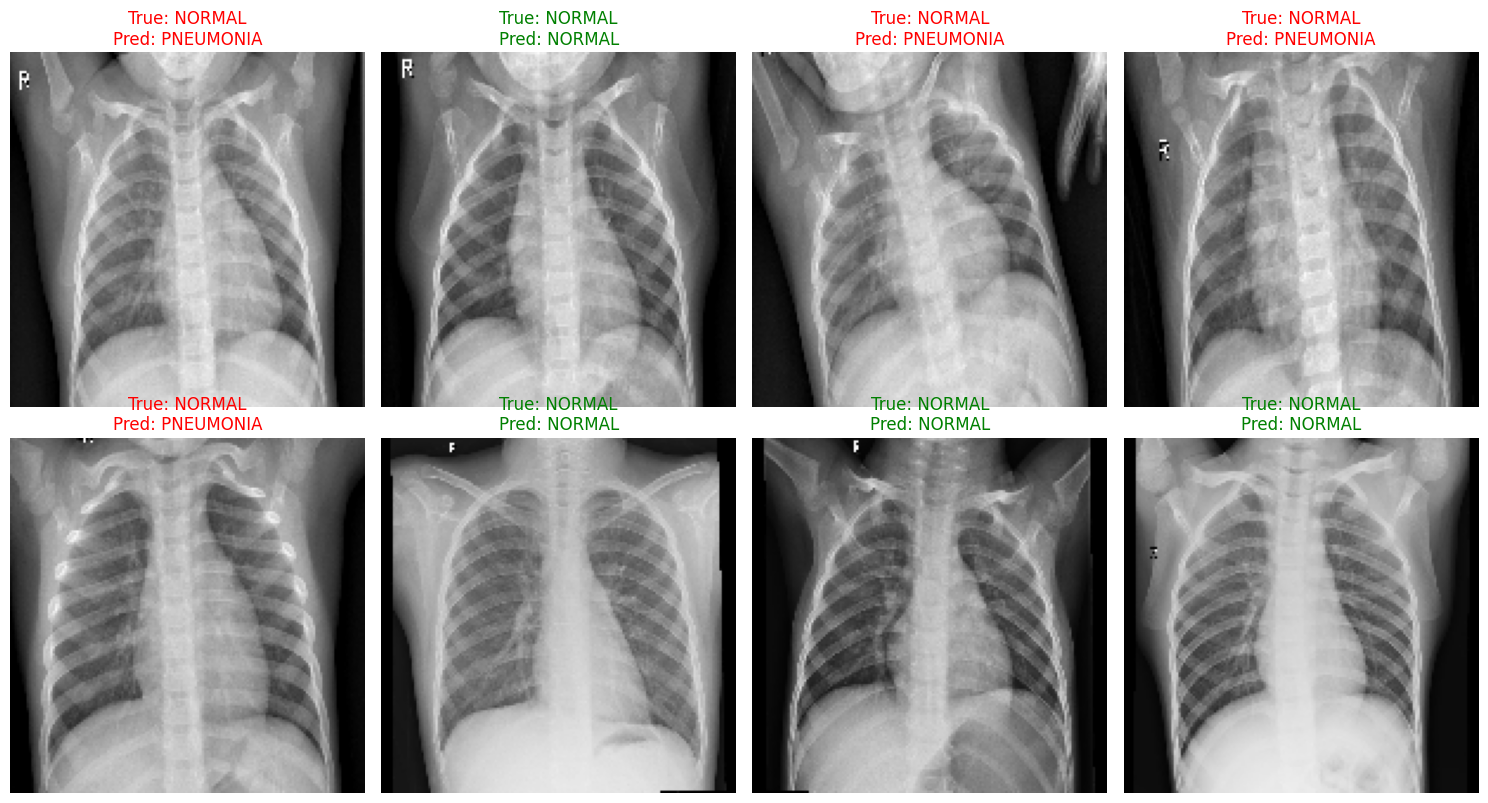

In [11]:
# Test Prediction Sanity Check

import random

# Get a few test image paths and their true labels
class_indices = {v: k for k, v in test_generator.class_indices.items()}
image_batch, label_batch = next(test_generator)

# Predict on batch
pred_batch = model.predict(image_batch)
pred_labels = (pred_batch > 0.5).astype(int)

# Show some predictions
plt.figure(figsize=(15, 8))
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(image_batch[i])
    true_label = class_indices[label_batch[i]]
    predicted_label = class_indices[pred_labels[i][0]]
    color = "green" if true_label == predicted_label else "red"
    ax.set_title(f"True: {true_label}\nPred: {predicted_label}", color=color)
    plt.axis("off")
plt.tight_layout()
plt.show()
